In [1]:
from pathlib import Path 
import os
import torch
from transformers import MarianMTModel, MarianTokenizer
import logging
from datetime import datetime

/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f'@@Configuration START@@')

@@Configuration START@@


In [3]:
# Define configuration 
batch_size = 128
d_model = 256 
n_head = 8
max_len = 80
ffn_hidden = 512
n_layers=4 
drop_prob=0.1
epochs=30
init_lr = 0.00 # having warmup step
eps = 5e-9
weight_decay = 5e-4
warmup_steps=1500
clip = 1

print(f'batch_size: {batch_size}')
print(f'd_model: {d_model}')
print(f'n_head: {n_head}') 
print(f'max_len: {max_len}') 
print(f'ffn_hidden: {ffn_hidden}')
print(f'n_layers: {n_layers}')
print(f'drop_prob: {drop_prob}')
print(f'epochs: {epochs}')
print(f'init_lr: {init_lr}')
print(f'weight_decay: {weight_decay}')
print(f'clip: {clip}')

batch_size: 64
d_model: 400
n_head: 8
max_len: 128
ffn_hidden: 1200
n_layers: 4
drop_prob: 0.1
epochs: 50
init_lr: 0.0
weight_decay: 0.0005
clip: 1


In [4]:
# Configure Device 


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA as device")
else:
    # Check that MPS is available
    if not torch.backends.mps.is_available():
        if not torch.backends.mps.is_built():
            print("MPS not available because the current PyTorch install was not "
                  "built with MPS enabled.")
        else:
            print("MPS not available because the current MacOS version is not 12.3+ "
                  "and/or you do not have an MPS-enabled device on this machine.")
        device = torch.device("cpu")
        print("Using CPU as device")
    else:
        device = torch.device("mps")
        print("Using MPS as device")
    
torch.set_default_device(device)

Using MPS as device


In [5]:
# Define tokenizers
TOKENIZERS_PARALLELISM = True

kr_tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')
en_tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')

enc_voc_size = kr_tokenizer.vocab_size
dec_voc_size = en_tokenizer.vocab_size

print(f'Using kr_tokenizer: Helsinki-NLP/opus-mt-ko-en')
print(f'kr_tokenizer_voc_size(enc_voc_size): {enc_voc_size}')

print(f'Using en_tokenizer: Helsinki-NLP/opus-mt-ko-en')
print(f'en_tokenizer_voc_size(dec_voc_size): {dec_voc_size}')

# Define some variables that are going to be used in future
src_pad_token = kr_tokenizer.pad_token_id
src_eos_token = kr_tokenizer.eos_token_id

trg_pad_token = en_tokenizer.pad_token_id
trg_sos_token = en_tokenizer.bos_token_id
trg_eos_token = en_tokenizer.eos_token_id

print(f'src_pad_token: {src_pad_token}')
print(f'src_eos_token: {src_eos_token}')
print(f'trg_pad_token: {trg_pad_token}')
print(f'trg_sos_token: {trg_sos_token}')
print(f'trg_eos_token: {trg_eos_token}')

/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Using kr_tokenizer: Helsinki-NLP/opus-mt-ko-en
kr_tokenizer_voc_size(enc_voc_size): 65001
Using en_tokenizer: Helsinki-NLP/opus-mt-ko-en
en_tokenizer_voc_size(dec_voc_size): 65001
src_pad_token: 65000
src_eos_token: 0
trg_pad_token: 65000
trg_sos_token: None
trg_eos_token: 0


In [6]:
# Test tokenizers 
tmp_kr_sentence = "오늘 하교길에 길고양이를 보았는데, 너무 귀여워서 집에 데려가고 싶었다. 하지만 그러지는 않았다."
tmp_en_sentence = "The cat I saw during heading home today was so cute, that I wanted to bring it to home."

tmp_kr_tokenized = kr_tokenizer(tmp_kr_sentence, add_special_tokens=True, padding="max_length", max_length=256, truncation=True)
# tmp_en_tokenized = en_tokenizer(tmp_en_sentence, add_special_tokens=True, padding="max_length", max_length=256, truncation=True)

# print(tmp_kr_tokenized)
# print(kr_tokenizer.convert_ids_to_tokens(tmp_kr_tokenized.input_ids))
# print(en_tokenizer.convert_ids_to_tokens(tmp_en_tokenized.input_ids))
# print(tmp_kr_tokenized.input_ids)
# print(kr_tokenizer.decode(tmp_kr_tokenized.input_ids, skip_special_tokens=True))

# check if both tokenizer has pad token 
# print(kr_tokenizer.pad_token)
# print(en_tokenizer.pad_token)

In [7]:
# Define path configuration for the project 
project_dir = Path(os.getcwd()).parent
rawdata_dir = project_dir / "data"
data_dir = project_dir / "preprocessed"
model_dir = project_dir / "models"

rawdata_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)
model_dir.mkdir(parents=True, exist_ok=True)

print(f'project_dir: {project_dir}')
print(f'rawdata_dir: {rawdata_dir}')
print(f'data_dir: {data_dir}')

project_dir: /Users/ball/Documents/workspace/transformer-tutorial
rawdata_dir: /Users/ball/Documents/workspace/transformer-tutorial/data
data_dir: /Users/ball/Documents/workspace/transformer-tutorial/preprocessed


In [8]:
# Define learning rate scheduler. 
# If you want to modify the logic of Scheduler, please modify this class 

class LRScheduler:
    def __init__(self, optimizer, d_model, warmup_steps, LR_scale=1): 
        self.optimizer = optimizer
        self.step_count = 0 
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.LR_scale = LR_scale
        self._d_model_factor = self.LR_scale * (self.d_model ** -0.5)
    def step(self): 
        self.step_count += 1 
        lr = self.calculate_learning_rate()
        self.optimizer.param_groups[0]['lr'] = lr 
    def calculate_learning_rate(self): 
        minimum_factor = min(self.step_count ** -0.5, self.step_count * self.warmup_steps ** -1.5)
        return self._d_model_factor * minimum_factor

In [9]:
# Configure Logger 
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

logging_dir = project_dir / "logs" 

logging_dir.mkdir(parents=True, exist_ok=True)

log_file = logging_dir / f'log_{timestamp}.log'

logger = logging.getLogger('transformer_log')
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)

In [10]:
print(f'@@Configuration END@@')

@@Configuration END@@


In [1]:
%run ../config/config.ipynb

/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


@@Configuration START@@
batch_size: 64
d_model: 400
n_head: 8
max_len: 128
ffn_hidden: 1200
n_layers: 4
drop_prob: 0.1
epochs: 50
init_lr: 0.0
weight_decay: 0.0005
clip: 1
Using MPS as device


/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Using kr_tokenizer: Helsinki-NLP/opus-mt-ko-en
kr_tokenizer_voc_size(enc_voc_size): 65001
Using en_tokenizer: Helsinki-NLP/opus-mt-ko-en
en_tokenizer_voc_size(dec_voc_size): 65001
src_pad_token: 65000
src_eos_token: 0
trg_pad_token: 65000
trg_sos_token: None
trg_eos_token: 0
project_dir: /Users/ball/Documents/workspace/transformer-tutorial
rawdata_dir: /Users/ball/Documents/workspace/transformer-tutorial/data
data_dir: /Users/ball/Documents/workspace/transformer-tutorial/preprocessed
@@Configuration END@@


In [2]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd 
import torch

In [3]:
train_data_path = data_dir / "train.parquet"
test_data_path = data_dir / "test.parquet"
validation_data_path = data_dir / "validation.parquet"

df_train = pd.read_parquet(path=train_data_path)
df_test = pd.read_parquet(path=test_data_path)
df_validation = pd.read_parquet(path=validation_data_path)

class en2kr_Train_Dataset(Dataset): 
    def __init__(self, max_len): 
        self.data = df_train
        
    def __len__(self): 
        return len(self.data) 

    def __getitem__(self, idx): 
        row = self.data.iloc[[idx]]
        en_sentence = row["english"].item()
        kr_sentence = row["korean"].item()
        
        return kr_sentence, en_sentence
        
class en2kr_Test_Dataset(Dataset): 
    def __init__(self, max_len): 
        self.data = df_test
        
    def __len__(self): 
        return len(self.data) 

    def __getitem__(self, idx): 
        row = self.data.iloc[[idx]]
        en_sentence = row["english"].item()
        kr_sentence = row["korean"].item()
        
        return kr_sentence, en_sentence

class en2kr_Validation_Dataset(Dataset): 
    def __init__(self, max_len): 
        self.data = df_validation
        
    def __len__(self): 
        return len(self.data) 

    def __getitem__(self, idx): 
        row = self.data.iloc[[idx]]
        en_sentence = row["english"].item()
        kr_sentence = row["korean"].item()
        
        return kr_sentence, en_sentence

In [4]:
df_train[0:3]

,korean,english
1239860,롯데면세점은 LDF페이 오픈기념으로 다채로운 증정혜택을 준비 중이다.,LOTTE Duty Free Shop is preparing a variety of...
865809,너는 그저 위를 보고 스스로를 자랑스러워해.,Just look up and be proud of yourself.
112285,왜 공개하지 못하겠다는 것인지 이세영 기자가 취재했습니다.,Reporter Lee Se-yeong covered why it insisted ...


In [5]:
train_dataset = en2kr_Train_Dataset(max_len=max_len)
test_dataset = en2kr_Test_Dataset(max_len=max_len)

train_dataloader = DataLoader(train_dataset,pin_memory=True, drop_last=True, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
test_dataloader = DataLoader(test_dataset,pin_memory=True, drop_last=True, batch_size=batch_size, generator=torch.Generator(device=device))

# Transformer Model Implementation 


In [1]:
# import required packages
import torch 
import torch.nn as nn 
import math 

In [2]:
%%capture 
%run ../config/config.ipynb

In [3]:
# Define a Token Embedding 
class TokenEmbeddings(nn.Embedding): 
    """
    Converting token into embedding vector
    """
    def __init__(self, vocab_size, d_model):
        """
        class for token embedding without positional encoding
        This layer transforms an seq_len token_ids -> (seq_len, d_model)
        Assigning (vector of size d_model) to each tokens

        :param vocab_size: number of vocabs that TokenEmbeddings can handle
        :param d_model: dimension of embedding vector
        """
        super(TokenEmbeddings, self).__init__(vocab_size, d_model, padding_idx=65000)

# Define Positional Encoding 
class PositionalEncoding(nn.Module): 
    """ 
    compute reusable sinusoid positional encoding
    """
    def __init__(self, d_model, max_len, device): 
        """
        construct sinusoid positional encoding that is going to be reused everytime when it is needed

        :param d_model: dimension of embedding vector
        :param max_len: maximum sequence length of token(a.k.a window size of attention method)
        """
        super(PositionalEncoding, self).__init__()

        # define a max_len * d_model size encoding matrix
        self.encoding = torch.zeros(max_len, d_model, device=device)

        # since positional encoding is not learnable, we turn off the gradient engine
        self.encoding.requires_grad = False

        # define a position at the sequence
        pos = torch.arange(0, max_len, device=device)
        # expand the max_len vector to max_len * 1 matrix 
        pos = pos.float().unsqueeze(dim=1)

        _2i = torch.arange(0, d_model, step=2, device=device).float()

        # define a sinusoid positional encoding
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x): 
        batch_size, seq_len = x.shape

        return self.encoding[:seq_len, :]

# Define Transformer Embedding 
class TransformerEmbedding(nn.Module): 
    """
    token embedding + positional encoding
    """
    def __init__(self, vocab_size, d_model, max_len, drop_prob, device): 
        """
        initialize the embedding class for word+position embedding

        :param vocab_size: number of vocabs that TokenEmbeddings can handle
        :param d_model: dimension of embedding vector
        :param max_len: maximum sequence length of token(a.k.a window size of attention method)
        :param drop_prob: dropout probability to reduce overfitting
        """
        super(TransformerEmbedding, self).__init__()
        self.token_emb = TokenEmbeddings(vocab_size, d_model)
        self.position_emb = PositionalEncoding(d_model, max_len, device)
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x): 
        tok_emb = self.token_emb(x)
        pos_emb = self.position_emb(x)

        return self.dropout(tok_emb+pos_emb)


In [4]:
# Define Attention Block 
class AttentionBlock(nn.Module): 
    """
    compute scale dot product attention for Query, Key, Value
    """
    def __init__(self):
        super(AttentionBlock, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None, eps=1e-12): 
        batch_size, head, length, d_tensor = k.shape

        # calculate the k_T
        k_T = k.transpose(2, 3)

        # calculate the attention weight 
        att_weight = (q @ k_T) / math.sqrt(d_tensor)

        # if there are any masks that needs to be applied
        if mask is not None:
            att_weight = att_weight.masked_fill(mask == 0, -10000)

        # calculate the softmax 
        # att_weight shape: batch_size, head, seq_len_query, seq_len_key
        att_weight = self.softmax(att_weight)

        # att_weight @ v shape: batch_size, head, seq_len_query, d_tensor
        return att_weight @ v, att_weight

# Define MultiHeadAttention Block 
class MultiHeadAttentionBlock(nn.Module): 
    """
    define multi head attention block using AttentionBlock module
    """
    def __init__(self, d_model, n_head): 
        """
        Multi-head self-attention utilize the parallelism of GPU

        :param d_model: dimension of embedding vector
        :param n_head: number of heads
        """
        super(MultiHeadAttentionBlock, self).__init__()
        self.n_head = n_head
        self.attention = AttentionBlock()
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)

        # in the paper, d_v = d_k = d_q
        self.Wv = nn.Linear(d_model, d_model)

        self.Wconcat = nn.Linear(d_model, d_model)

    def split(self, tensor): 
        """
        split the tensor by number of head 

        :param tensor: tensor of shape batch_size  * seq_len * d_model
        :return: return tensor of shape batch_size * n_head * seq_len * d_tensor
        """
        batch_size, seq_len, d_model = tensor.shape 

        d_tensor = d_model // self.n_head

        tensor = tensor.view(batch_size, seq_len, self.n_head, d_tensor).transpose(1, 2)

        return tensor 

    def concat(self, tensor): 
        """
        concat tensor. Inverse operation of split

        :param tensor: tensor of shape batch_size * n_head * seq_len * d_tensor 
        :return: return tensor of shape batch_size * seq_len * d_model
        """
        batch_size, n_head, seq_len, d_tensor = tensor.shape

        d_model = n_head * d_tensor
        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        return tensor 
    

    def forward(self, q, k, v, mask=None): 
        # apply linear transformation to derive q, k, v 
        q, k, v = self.Wq(q), self.Wk(k), self.Wv(v)

        # split the tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # apply attention to q, k, v 
        out, attn_weights = self.attention(q, k, v, mask=mask)

        # current attn_weights shape is batch_size * n_head * q_len * k_len
        # mean it by dim 1
        # eventually changing shape into batch_size * q_len * k_len
        attn_weight = attn_weights.mean(dim=1)

        # concat 
        out = self.concat(out)

        # apply concat weight 
        out = self.Wconcat(out)
        return out, attn_weight
        

In [5]:
# # Define LayerNorm 
# class LayerNorm(nn.Module): 
#     """
#     Normalize all features for each samples. 
#     """
#     def __init__(self, d_model, eps=1e-6): 
#         super(LayerNorm, self).__init__()
#         self.gamma = nn.Parameter(torch.ones(d_model))
#         self.beta = nn.Parameter(torch.zeros(d_model))
#         self.eps = eps 

#     def forward(self, x): 
#         mean = x.mean(-1, keepdim=True)
#         var = x.var(-1, keepdim=True, unbiased=False)

#         out = (x - mean) / torch.sqrt(var + self.eps)
#         out = self.gamma * out + self.beta

#         return out 

In [6]:
# define FeedForward Network 
class FeedForwardBlock(nn.Module): 
    def __init__(self, d_model, hidden, drop_prob=0.1): 
        super(FeedForwardBlock, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden) 
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x): 
        x = self.linear1(x) 
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x) 
        return x 

In [7]:
# Define Encoder Layer 
class EncoderLayer(nn.Module): 
    def __init__(self, d_model, ffn_hidden, n_head, drop_prob): 
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttentionBlock(d_model, n_head)
        self.norm1 = nn.LayerNorm(d_model) 
        self.dropout1 = nn.Dropout(drop_prob)

        self.ffn = FeedForwardBlock(d_model, ffn_hidden, drop_prob)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(drop_prob)

    def forward(self, x, src_mask): 
        residual = x 
        x = self.norm1(x)
        x, attn_weight = self.attention(q=x, k=x, v=x, mask=src_mask)

        x = self.dropout1(x) 
        x = self.norm1(x + residual)

        residual = x 
        x = self.ffn(x) 

        x =  self.dropout2(x)
        x = x + residual

        return x, attn_weight

# Define Decoder Layer 
class DecoderLayer(nn.Module): 
    def __init__(self, d_model, ffn_hidden, n_head, drop_prob): 
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttentionBlock(d_model, n_head)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.enc_dec_attention = MultiHeadAttentionBlock(d_model, n_head)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = FeedForwardBlock(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, dec, enc, trg_mask, src_mask): 
        residual = dec
        dec = self.norm1(x)
        
        x, attn_weight1 = self.self_attention(q=dec, k=dec, v=dec, mask=trg_mask)

        x = self.dropout1(x)
        x = self.norm2(x + residual)

        residual = x 
        x, attn_weight2 = self.enc_dec_attention(q=x, k=enc, v=enc, mask=src_mask)
        x = self.dropout2(x) 
        x = self.norm3(x + residual)

        residual = x 
        x = self.ffn(x)
        x = self.dropout3(x)
        x = x + residual

        return x, attn_weight1, attn_weight2

In [8]:
# Define Encoder Model
class Encoder(nn.Module): 
    """
    Encoder for Transformer
    """
    def __init__(self, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device): 
        super(Encoder, self).__init__()
        self.emb = TransformerEmbedding(d_model=d_model, max_len=max_len, vocab_size=enc_voc_size, drop_prob=drop_prob, device=device)
        self.layers = nn.ModuleList([EncoderLayer(d_model=d_model, ffn_hidden=ffn_hidden, n_head=n_head, drop_prob=drop_prob) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, src_mask): 
        x = self.emb(x) 
        attn_weights = []
        # get the mean of attention map batch_size * seq_len_src * seq_len_src 
        for layer in self.layers: 
            x, attn_weight = layer(x, src_mask)
            attn_weights.append(attn_weight)

        x = self.norm(x)

        return x, torch.mean(torch.stack(attn_weights), dim=0)

        
class Decoder(nn.Module): 
    """
    Decoder for Transformer
    """
    def __init__(self, dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device): 
        super(Decoder, self).__init__()
        self.emb = TransformerEmbedding(d_model=d_model, max_len=max_len, vocab_size=dec_voc_size, drop_prob=drop_prob, device=device)

        self.layers = nn.ModuleList([DecoderLayer(d_model=d_model, ffn_hidden=ffn_hidden, n_head=n_head, drop_prob=drop_prob) for _ in range(n_layers)])

        self.linear = nn.Linear(d_model, dec_voc_size)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, trg, enc_src, trg_mask, src_mask): 
        trg = self.emb(trg)
        attn_weights_1 = []
        attn_weights_2 = []
        for layer in self.layers: 
            trg, attn_weight_1, attn_weight_2 = layer(trg, enc_src, trg_mask, src_mask) 
            attn_weights_1.append(attn_weight_1)
            attn_weights_2.append(attn_weight_2)

        trg = self.norm(trg)
        output = self.linear(trg)
        return output, torch.mean(torch.stack(attn_weights_1), dim=0), torch.mean(torch.stack(attn_weights_2), dim=0)
    

# Define Transformer Model 
class Transformer(nn.Module): 
    """
    Transformer Model
    """
    def __init__(self, src_pad_token, trg_pad_token, enc_voc_size, dec_voc_size, n_head, max_len, d_model, ffn_hidden, n_layers, drop_prob, device): 
        """
        Constructing Transformer Model 

        :param src_pad_token: embedding vector that represents <pad> in source 
        :param trg_pad_token: embedding vector that represents <pad> in target 
        :params enc_voc_size: number of vocabs that encoderEmbedder can handle
        :params dec_voc_size: number of vocabs that decoderEmbedder can handle
        :params ffn_hidden: hidden vector dimension for fastfeedforward layer 
        :params n_layers: number of EncoderLayer/DecoderLayer used
        :params drop_prob: dropout probability
        """
        super(Transformer, self).__init__()
        
        self.src_pad_token = src_pad_token
        self.trg_pad_token = trg_pad_token
        self.device = device
        self.encoder = Encoder(d_model=d_model, n_head=n_head, max_len=max_len, ffn_hidden=ffn_hidden, enc_voc_size=enc_voc_size, drop_prob=drop_prob, n_layers=n_layers, device=device)
        self.decoder = Decoder(d_model=d_model, n_head=n_head, max_len=max_len, ffn_hidden=ffn_hidden, dec_voc_size=dec_voc_size, drop_prob=drop_prob, n_layers=n_layers, device=device)
    
    def make_src_mask(self, src): 
        # print(f'src: {src}')
        # print(f'src_pad_token: {self.src_pad_token}')
        # print(f'src != self.src_pad_token: {src != self.src_pad_token}')
        src_mask = (src != self.src_pad_token).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_trg_mask(self, trg): 
        trg_pad_mask = (trg != self.trg_pad_token).unsqueeze(1).unsqueeze(3)
        trg_len = trg.shape[1]

        # make a look-ahead mask using torch.tril 
        # [[1 0 0]
        #  [1 1 0]
        #  [1 1 1]]
        trg_sub_mask = torch.tril(torch.ones(trg_len, trg_len)).type(torch.ByteTensor).to(self.device)

        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask
        
    
    def forward(self, src, trg): 
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src, enc_self_attn_weight = self.encoder(src, src_mask)
        output, dec_self_attn_weight, enc_dec_attn_weight = self.decoder(trg, enc_src, trg_mask, src_mask)

        # current output shape is batch_size * dec_voc_size, which is desirable. 
        # We don't need to apply softmax because we are going to use CrossEntropyLoss as loss function
        # which automatically applies log-softmax during calculation
        
        return output

# Train the Model using datas

In [6]:
%%capture
%run ../config/config.ipynb
%run ./data-loader.ipynb
%run ./Transformer.ipynb

In [7]:
from torch.optim import Adam
from datetime import datetime
import torch 
from tqdm import tqdm

In [8]:
# Prepare the model 
model = Transformer(
    src_pad_token=src_pad_token, 
    trg_pad_token=trg_pad_token, 
    enc_voc_size=enc_voc_size, 
    dec_voc_size=dec_voc_size, 
    n_head=n_head, 
    max_len=max_len, 
    d_model=d_model, 
    ffn_hidden=ffn_hidden, 
    n_layers=n_layers, 
    drop_prob=drop_prob, 
    device=device).to(device)

model.train()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'model parameter #: {count_parameters(model)}')
logger.info(f'model parameter #: {count_parameters(model)}')


model parameter #: 55257321


In [9]:
# Setup optimizer 
optimizer = Adam(params=model.parameters(), lr=init_lr, weight_decay=weight_decay, eps=eps, betas=(0.9, 0.98))

# Set Noam Scheduler
scheduler = LRScheduler(optimizer, d_model, warmup_steps)
# Setup loss function for training
loss_func = nn.CrossEntropyLoss(ignore_index=src_pad_token, label_smoothing=0.1)

# store lr rate history per 10 steps 
lr_history = []


In [9]:
def train_epoch(epoch_num): 
    train_epoch_loss = 0 

    for step, (kr_sentences, en_sentences) in tqdm(enumerate(train_dataloader)): 

        # tokenize kr_sentence 
        kr_tokenized = kr_tokenizer(kr_sentences, padding=True, truncation=True, max_length=max_len, return_tensors="pt").input_ids
        
        # tokenize en_sentence 
        # make en_sentence start with eos token(this is because current tokenizer don't have an sos token.)
        en_sentences = ['</s> ' + s for s in en_sentences]
        en_tokenized = en_tokenizer(en_sentences, padding=True, truncation=True, max_length=max_len, return_tensors="pt").input_ids
        
        optimizer.zero_grad()

        kr_tokenized = kr_tokenized.to(device)
        en_tokenized = en_tokenized.to(device)

        # out is the dec_voc_size vector 
        # during training, we exclude sep token 

        # remove eos token if the sentence is too long, and gets truncated.
        # so we can prevent early-stopping(early-eos) 
        # out: batch_size * max_len * dec_voc_size
        out = model(kr_tokenized, en_tokenized[:, :-1])

        # remove sos token from en_tokenized when calculating loss because out will not include eos token in front of the sentence. 
        # en_tokenized: batch_size * (max_len-1)
        en_tokenized = en_tokenized[:, 1:].to(device)

        # out: batch_size * (max_len - 1) * dec_voc_size
        out = out.permute(0, 2, 1).to(device)

        loss = loss_func(out, en_tokenized)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        scheduler.step()

        train_epoch_loss += loss.item()
        
        if step % 200 == 0:
            print(f'    EPOCH #{epoch_num} STEP #{step} | loss: {loss.item()}, avg_loss: {train_epoch_loss / (step + 1)}')
            logger.info(f'    EPOCH #{epoch_num} STEP #{step} | loss: {loss.item()}, avg_loss: {train_epoch_loss / (step + 1)}')
        
        # for every 10 steps, log the learning rate 
        if step % 10 == 0: 
            lr_history.append(optimizer.param_groups[0]["lr"])

    train_step_loss = train_epoch_loss / (step+1)
    # After training epoch, do evaluation 

    return train_step_loss

In [10]:
# evaluate the model 
def evaluate(): 
    model.eval()
    test_epoch_loss = 0 
    test_bleu_loss = 0
    
    with torch.no_grad(): 
        for step, (kr_sentences, en_sentences) in tqdm(enumerate(test_dataloader)): 
            # tokenize kr_sentence 
            kr_tokenized = kr_tokenizer(kr_sentences, padding=True, truncation=True, max_length=max_len, return_tensors="pt").input_ids
            
            # tokenize en_sentence 
            # make en_sentence start with eos token(this is because current tokenizer don't have an sos token.)
            en_sentences = ['</s> ' + s for s in en_sentences]
            en_tokenized = en_tokenizer(en_sentences, padding=True, truncation=True, max_length=max_len, return_tensors="pt").input_ids

            kr_tokenized = kr_tokenized.to(device)
            en_tokenized = en_tokenized.to(device)


            # this does not remove the eos token 
            # FIXME 
            out = model(kr_tokenized, en_tokenized[:, :-1])
            

            # remove sos token from en_tokenized when calculating loss because out will not include sos token. 
            en_tokenized = en_tokenized[:, 1:].to(device)
    
            out = out.permute(0, 2, 1).to(device)
            
            loss = loss_func(out, en_tokenized)
            test_epoch_loss += loss.item()

            # calcuate the bleu 
            # TODO
        test_step_loss = test_epoch_loss / (step + 1)
    return test_step_loss

In [11]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
best_vloss = 100_000_000

for epoch in range(epochs):
    print(f'Epoch #{epoch} Start: current LR {optimizer.param_groups[0]["lr"]}')
    logger.info(f'Epoch #{epoch} Start: current LR {optimizer.param_groups[0]["lr"]}')
    
    train_loss = train_epoch(epoch)
    test_loss = evaluate()

    print(f'Epoch #{epoch} End: Train Loss {train_loss}, Test Loss {test_loss}')
    logger.info(f'Epoch #{epoch} End: Train Loss {train_loss}, Test Loss {test_loss}')

    if test_loss < best_vloss:
        best_vloss = test_loss 
        model_path = model_dir / f'model_{timestamp}_{epoch}' 
        torch.save(model.state_dict(), model_path) 
        logger.info(f'model test loss achieved a new record. saving the model...')

1it [00:00,  1.34it/s]

EPOCH #0 STEP #0 | loss: 11.167913436889648, avg_loss: 11.167913436889648


51it [00:29,  1.64it/s]

EPOCH #0 STEP #50 | loss: 11.144428253173828, avg_loss: 11.170808137631884


101it [00:57,  2.01it/s]

EPOCH #0 STEP #100 | loss: 11.07529354095459, avg_loss: 11.145308201855952


151it [01:24,  1.69it/s]

EPOCH #0 STEP #150 | loss: 10.903339385986328, avg_loss: 11.100729613904132


201it [01:48,  1.95it/s]

EPOCH #0 STEP #200 | loss: 10.793999671936035, avg_loss: 11.041111689894947


251it [02:13,  2.00it/s]

EPOCH #0 STEP #250 | loss: 10.62584400177002, avg_loss: 10.977308417696403


301it [02:38,  1.97it/s]

EPOCH #0 STEP #300 | loss: 10.339343070983887, avg_loss: 10.893966215393473


347it [03:00,  1.92it/s]


KeyboardInterrupt: 

In [1]:
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns
plt.rcParams['font.family'] = 'AppleGothic'

In [4]:
def draw_one_attention_map(idx, attn_weights, query, key):
    # attn_weight shape: (batch_size * query_len * key_len)
    # query shape: list size of query_len
    # key shape: list size of key_len
    # query and key are already decoded!!
    attn_weights = attn_weights.cpu()

    # crop only first 10s of query and key
    query = query[:20]
    key = key[:20]
    
    # draw one attention map given attn_weight, query, key
    # picking idx th data from the batch 
    batch_size, query_len, key_len = attn_weights.shape 
    
    if idx < 0 or idx >= batch_size:
        print(f'Invalid idx given. batch_size: {batch_size}, given index: {idx}')

    # pick from the batch 
    attn_weight = attn_weights[idx, :20, :20]

    attn_weight = attn_weight.squeeze(0)


    fig, ax = plt.subplots(figsize=[attn_weight.shape[1] * 1.5, attn_weight.shape[0]])
    sns.heatmap(attn_weight, annot=True, fmt=".2f", cbar=False, ax=ax, yticklabels=query, xticklabels=key)

    ax.set_yticklabels(query, rotation=45, fontsize=15)
    ax.set_xticklabels(key, rotation=60, fontsize=15)
    ax.xaxis.tick_top()
    ax.set_title(f'Average Attention Map', fontsize=12)

    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color('black')

    plt.tight_layout()
    plt.show()

In [1]:
%%capture
%run ../config/config.ipynb
%run ./Transformer.ipynb
%run ../utils/attn-map.ipynb

In [2]:
import torch

In [3]:
# import the model in the models/ directory 
model_name = "model_20241119_142930_2"
model_path = model_dir / model_name

In [4]:
# Load the trained model 
model = Transformer(
    src_pad_token=src_pad_token, 
    trg_pad_token=trg_pad_token, 
    enc_voc_size=enc_voc_size, 
    dec_voc_size=dec_voc_size, 
    n_head=n_head, 
    max_len=max_len, 
    d_model=d_model, 
    ffn_hidden=ffn_hidden, 
    n_layers=n_layers, 
    drop_prob=drop_prob, 
    device=device).to(device)

# load weights from the saved model 
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model.eval()

Transformer(
  (encoder): Encoder(
    (emb): TransformerEmbedding(
      (token_emb): TokenEmbeddings(65001, 400, padding_idx=1)
      (position_emb): PositionalEncoding()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (attention): MultiHeadAttentionBlock(
          (attention): AttentionBlock(
            (softmax): Softmax(dim=-1)
          )
          (Wq): Linear(in_features=400, out_features=400, bias=True)
          (Wk): Linear(in_features=400, out_features=400, bias=True)
          (Wv): Linear(in_features=400, out_features=400, bias=True)
          (Wconcat): Linear(in_features=400, out_features=400, bias=True)
        )
        (norm1): LayerNorm()
        (dropout1): Dropout(p=0.1, inplace=False)
        (ffn): FeedForwardBlock(
          (linear1): Linear(in_features=400, out_features=1200, bias=True)
          (linear2): Linear(in_features=1200, out_features=400, bias=True)
          (relu): ReLU()
   

In [5]:
# define a helper function 
def tensor2tokenid(tensor): 
    # convert tensor to tokenid 
    # by picking index that has max value 
    # use argmax 
    token_id = torch.argmax(tensor, dim=-1)
    return token_id

In [6]:
tmp = kr_tokenizer("안녕하세요", add_special_tokens=True, padding="max_length", max_length=max_len, truncation=True).input_ids 


In [7]:
# Create a inference function that takes korean sentence, and outputs english sentence.
# for generating english sentence, we are going to limit the output token length by limit_token_length
def inference(kr_sentence): 
    with torch.no_grad():
        limit_token_length = max_len - 1
        # since we are going to generete English sentence in autoregressive manner, 
        # we have to define the starting point.
        # make a max_len length tensor that first element is trg_sos_token, 
        # and others filled with trg_pad_token
        # reshape to set batch_size as 1 
        trg_token_ids = en_tokenizer.encode('</s>', return_tensors="pt", add_special_tokens=False).to(device)
        # trg_token_ids[0] = trg_eos_token
        trg_token_ids = trg_token_ids.reshape((1, -1)).to(device)
        print(trg_token_ids.shape)
        # print(trg_token_ids.type())
        
        # tokenize src sentence 
        src_token_ids = kr_tokenizer(kr_sentence, add_special_tokens=True, padding="max_length", max_length=max_len, truncation=True).input_ids

        src_tokens = kr_tokenizer.convert_ids_to_tokens(src_token_ids)
        
        src_token_ids = torch.tensor(src_token_ids).reshape((1, -1)).to(device)
        # print(src_token_ids.shape)
        # print(src_token_ids.type())
        
        # make src_mask and trg_mask
        src_mask = model.make_src_mask(src_token_ids)
        # print(src_mask)
    
        # get enc_src using model.encoder 
        # we can use whole transformer iteratively, but 
        # since we are going to reuse enc_src, 
        # we are going to cache it, and reuse it
        enc_src, enc_self_attn_map = model.encoder(src_token_ids, src_mask)

        # draw attn_map for enc_self_attn_map
        draw_one_attention_map(0, enc_self_attn_map, src_tokens, src_tokens)
        
        for idx in range(1, limit_token_length): 
            trg_mask = model.make_trg_mask(trg_token_ids)
            # print(trg_mask)
            # print(f'trg_token_ids: {trg_token_ids.shape}')
            # print(f'model.decoder(trg_token_ids, enc_src, trg_mask, src_mask)[0] shape: {model.decoder(trg_token_ids, enc_src, trg_mask, src_mask)[0].shape}')
            decoded, dec_self_attn_map, enc_dec_attn_map = model.decoder(trg_token_ids, enc_src, trg_mask, src_mask)
            next_token_tensor = decoded[0, -1, :]
            # print(f'next_token_tensor shape: {next_token_tensor.shape}')
            next_token_id = tensor2tokenid(next_token_tensor)
            # print(f'next_token_id: {next_token_id}')
    
            # append it to the trg 
            # print(f'trg_token_ids shape: {trg_token_ids.shape}')
            # print(f'next_token_id.reshape(1, -1) shape: {next_token_id.reshape(1, -1).shape}')
            trg_token_ids = torch.cat([trg_token_ids, next_token_id.reshape(1, -1)], dim=1)
            
            # break if next_token_id is end token 
            if next_token_id == trg_eos_token: 
                break

        print(f'shape of trg_token_ids: {trg_token_ids.shape}')
        trg_tokens = en_tokenizer.convert_ids_to_tokens(trg_token_ids.squeeze(0).tolist())

        print(f'shape of dec_self_attn_map: {dec_self_attn_map.shape}')
        print(f'shape of enc_dec_attn_map: {enc_dec_attn_map}')

        draw_one_attention_map(0, dec_self_attn_map, trg_tokens, trg_tokens)
        draw_one_attention_map(0, enc_dec_attn_map, trg_tokens, src_tokens)
    
        # convert trg into string 
        print(f'{trg_token_ids.reshape(-1)}')
        return en_tokenizer.decode(trg_token_ids.reshape(-1), skip_special_tokens=False)

torch.Size([1, 1])


/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/var/folders/qc/krghrss90j3_h3x_kbbgxj740000gn/T/ipykernel_41250/45132878.py:38: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


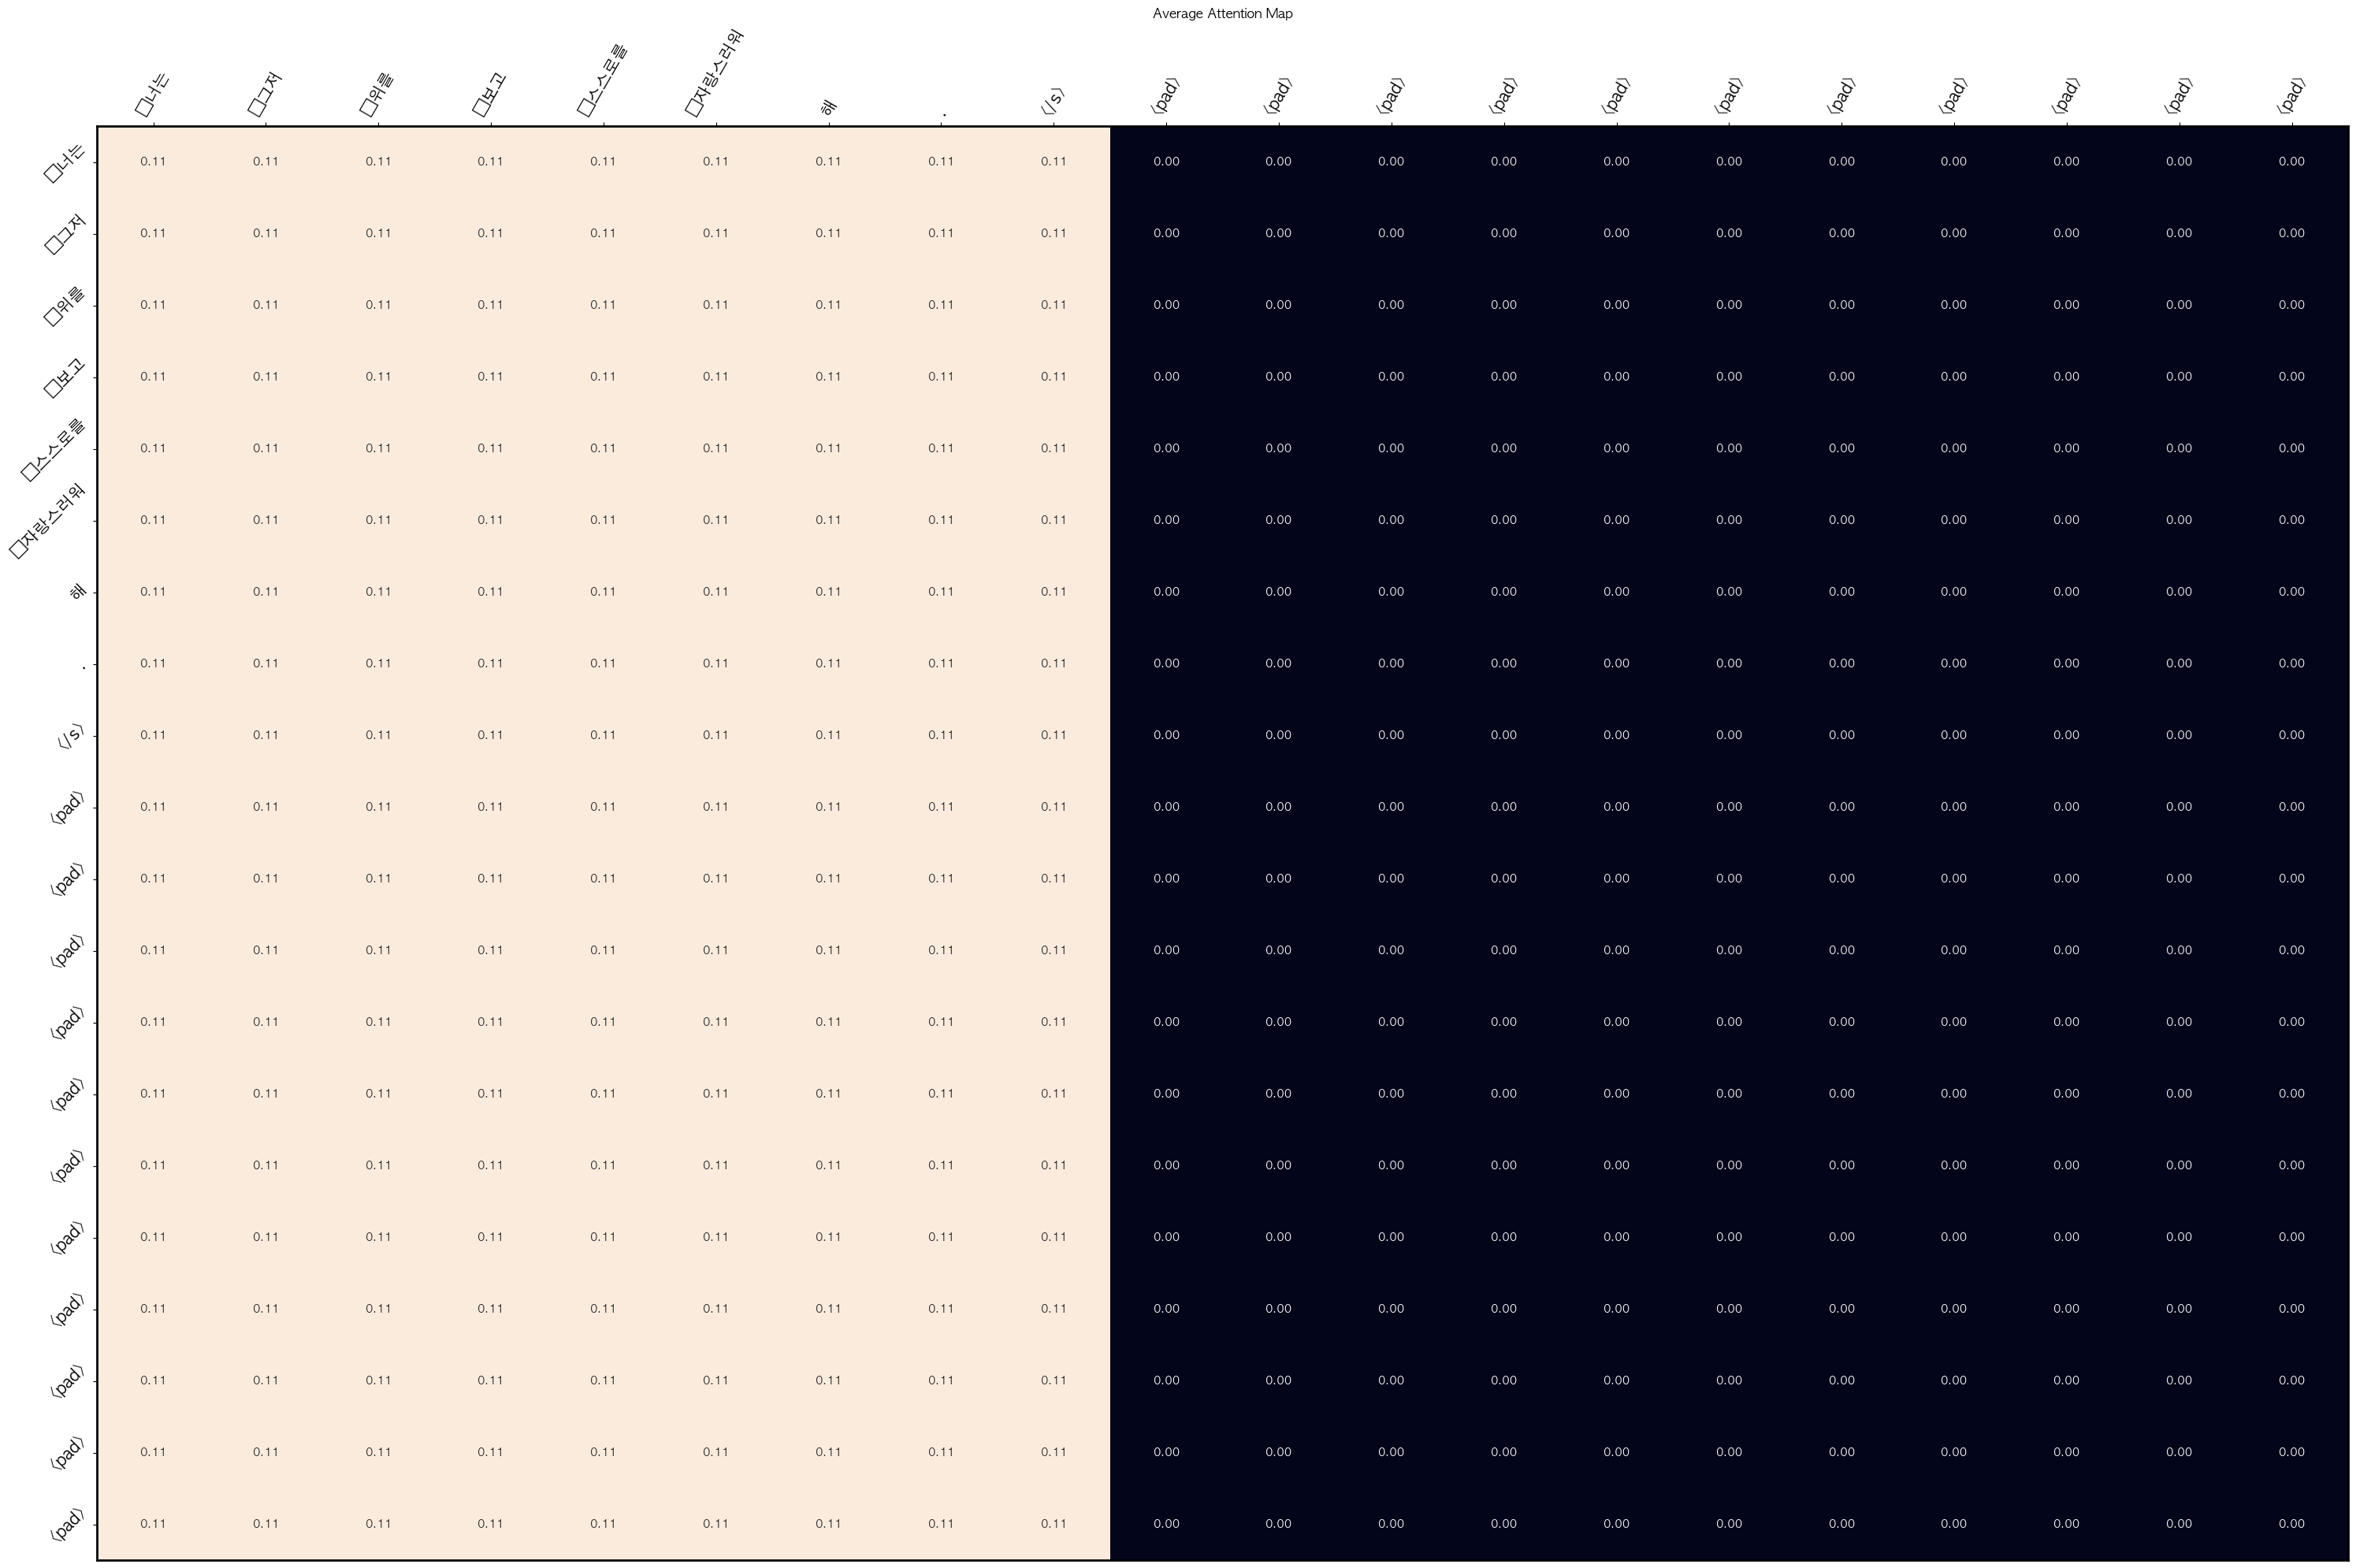

shape of trg_token_ids: torch.Size([1, 24])
shape of dec_self_attn_map: torch.Size([1, 23, 23])
shape of enc_dec_attn_map: tensor([[[0.1284, 0.1033, 0.1062,  ..., 0.0000, 0.0000, 0.0000],
         [0.1140, 0.1077, 0.1067,  ..., 0.0000, 0.0000, 0.0000],
         [0.1118, 0.1111, 0.1103,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1120, 0.1111, 0.1110,  ..., 0.0000, 0.0000, 0.0000],
         [0.1123, 0.1060, 0.1042,  ..., 0.0000, 0.0000, 0.0000],
         [0.1180, 0.1041, 0.1038,  ..., 0.0000, 0.0000, 0.0000]]],
       device='mps:0')


/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/var/folders/qc/krghrss90j3_h3x_kbbgxj740000gn/T/ipykernel_41250/45132878.py:38: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


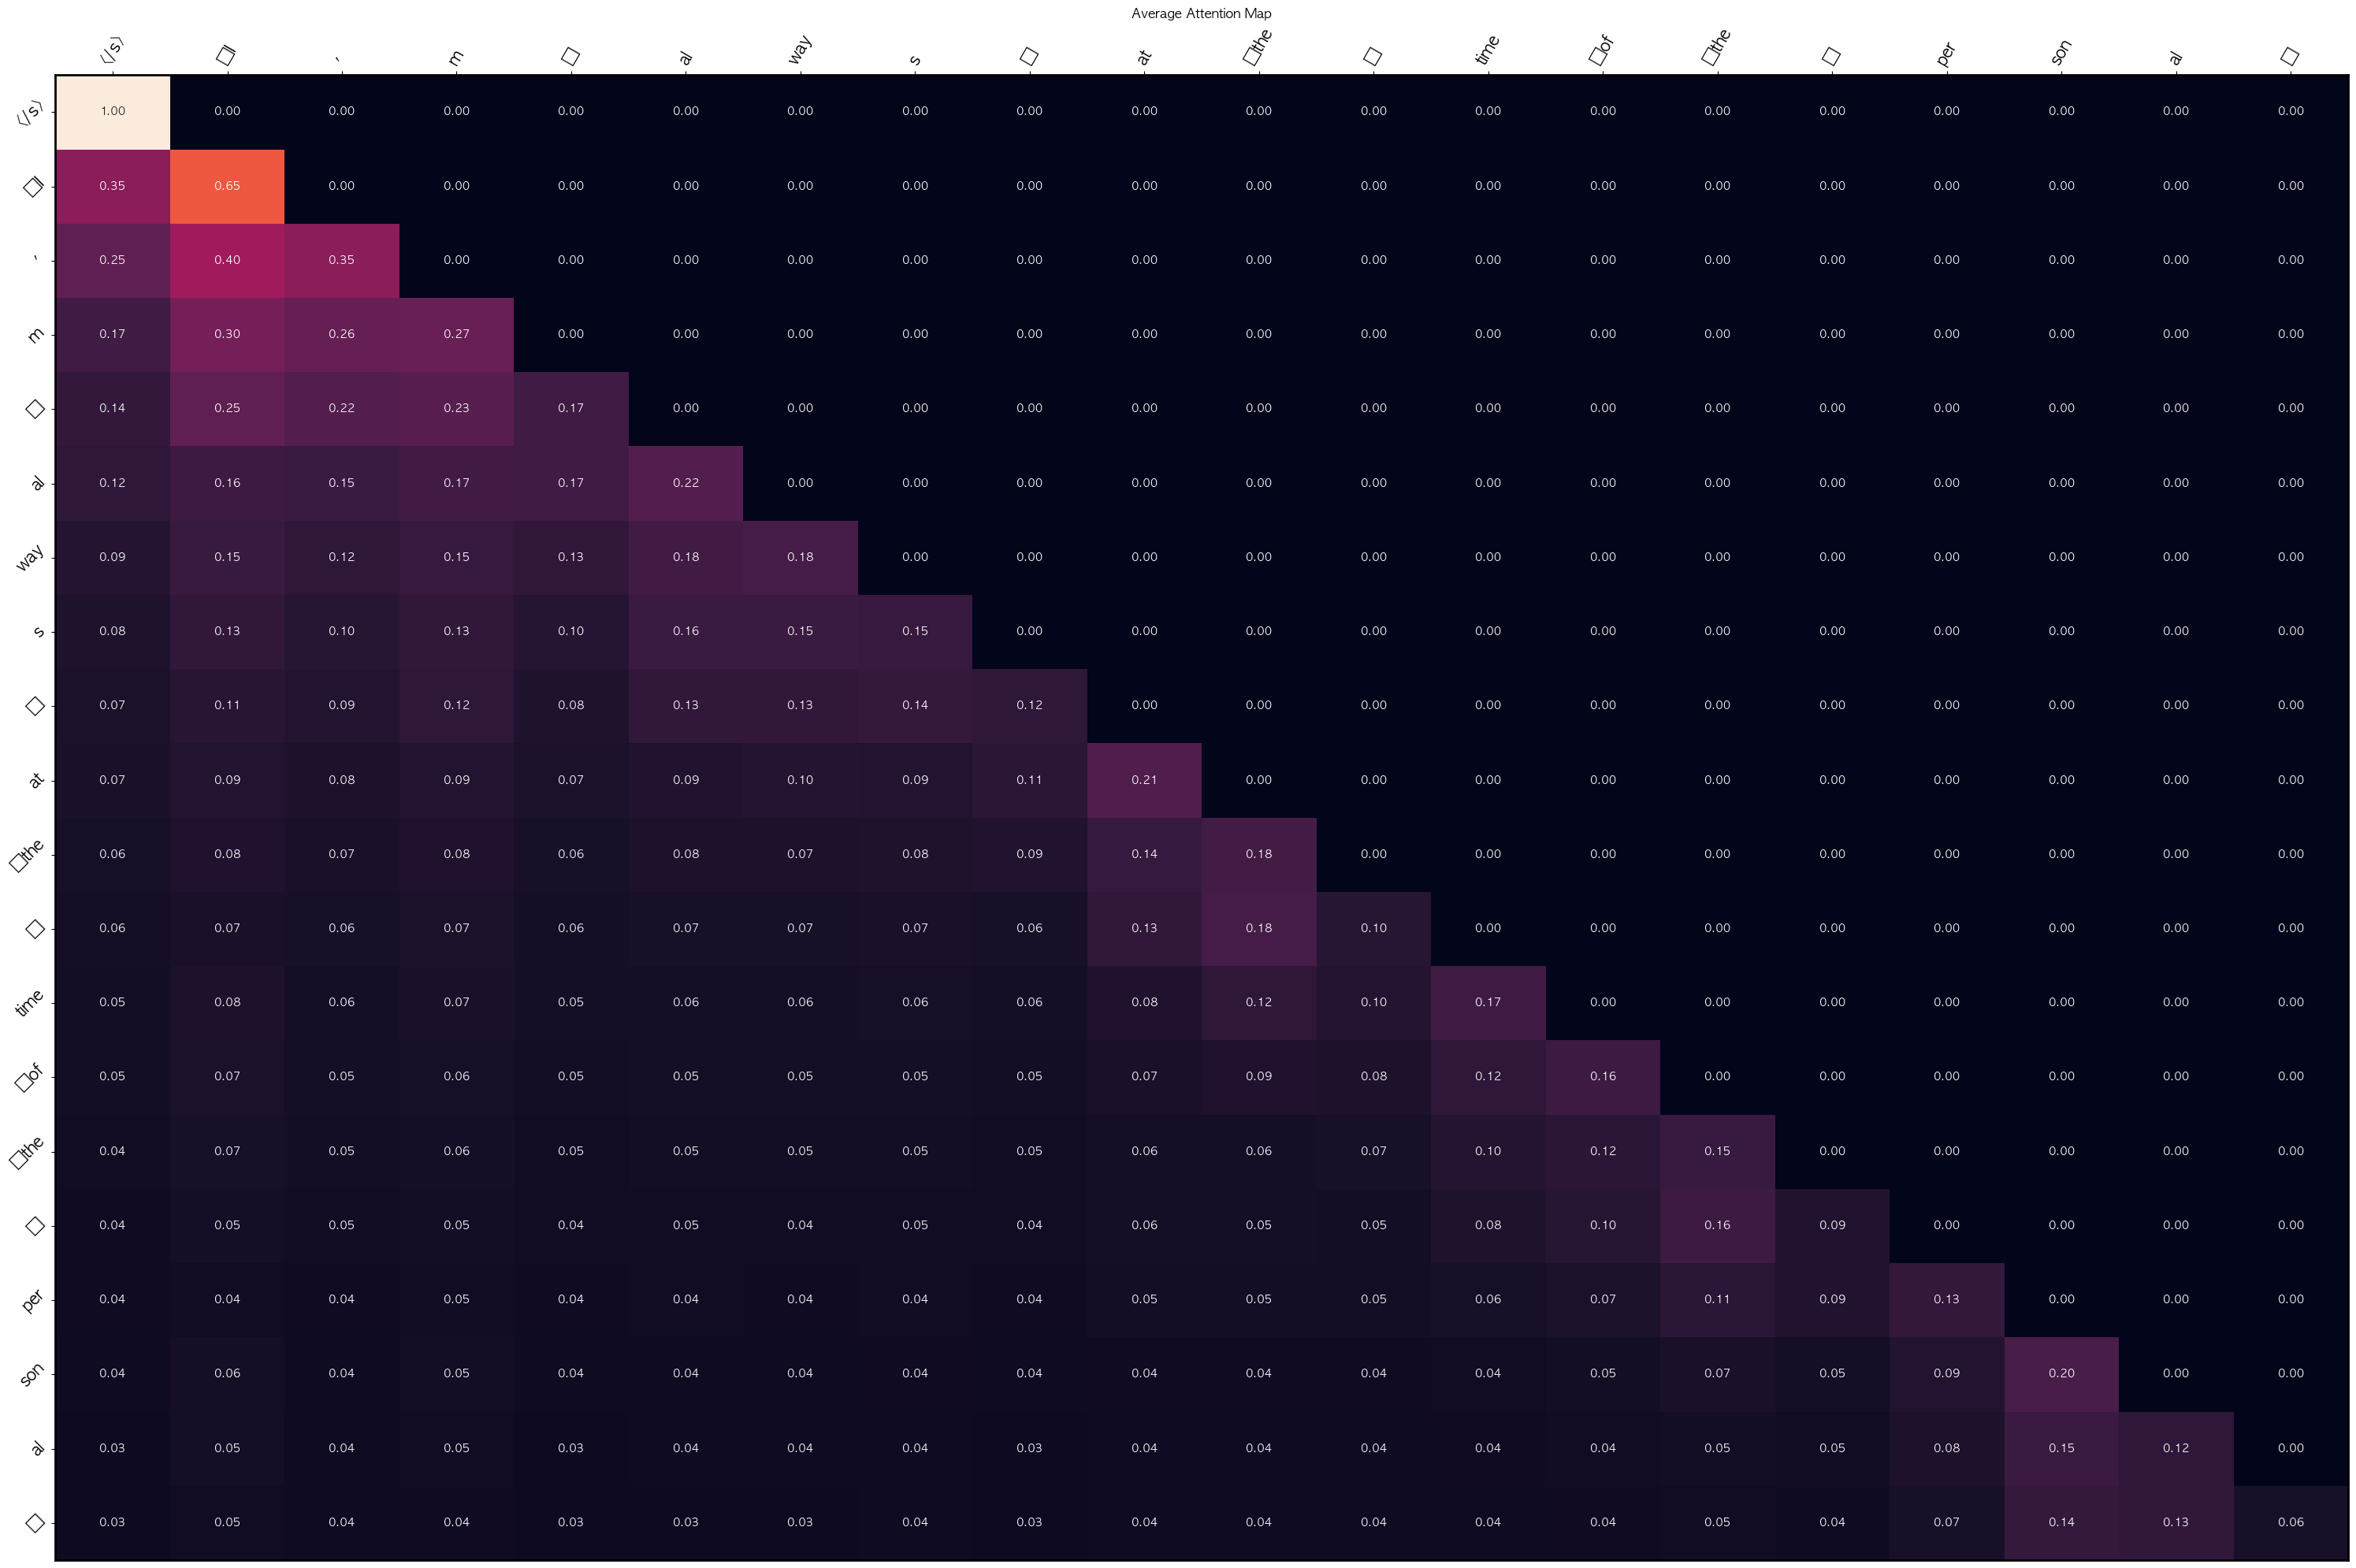

/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/var/folders/qc/krghrss90j3_h3x_kbbgxj740000gn/T/ipykernel_41250/45132878.py:38: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/ball/Documents/workspace/transformer-tutorial/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


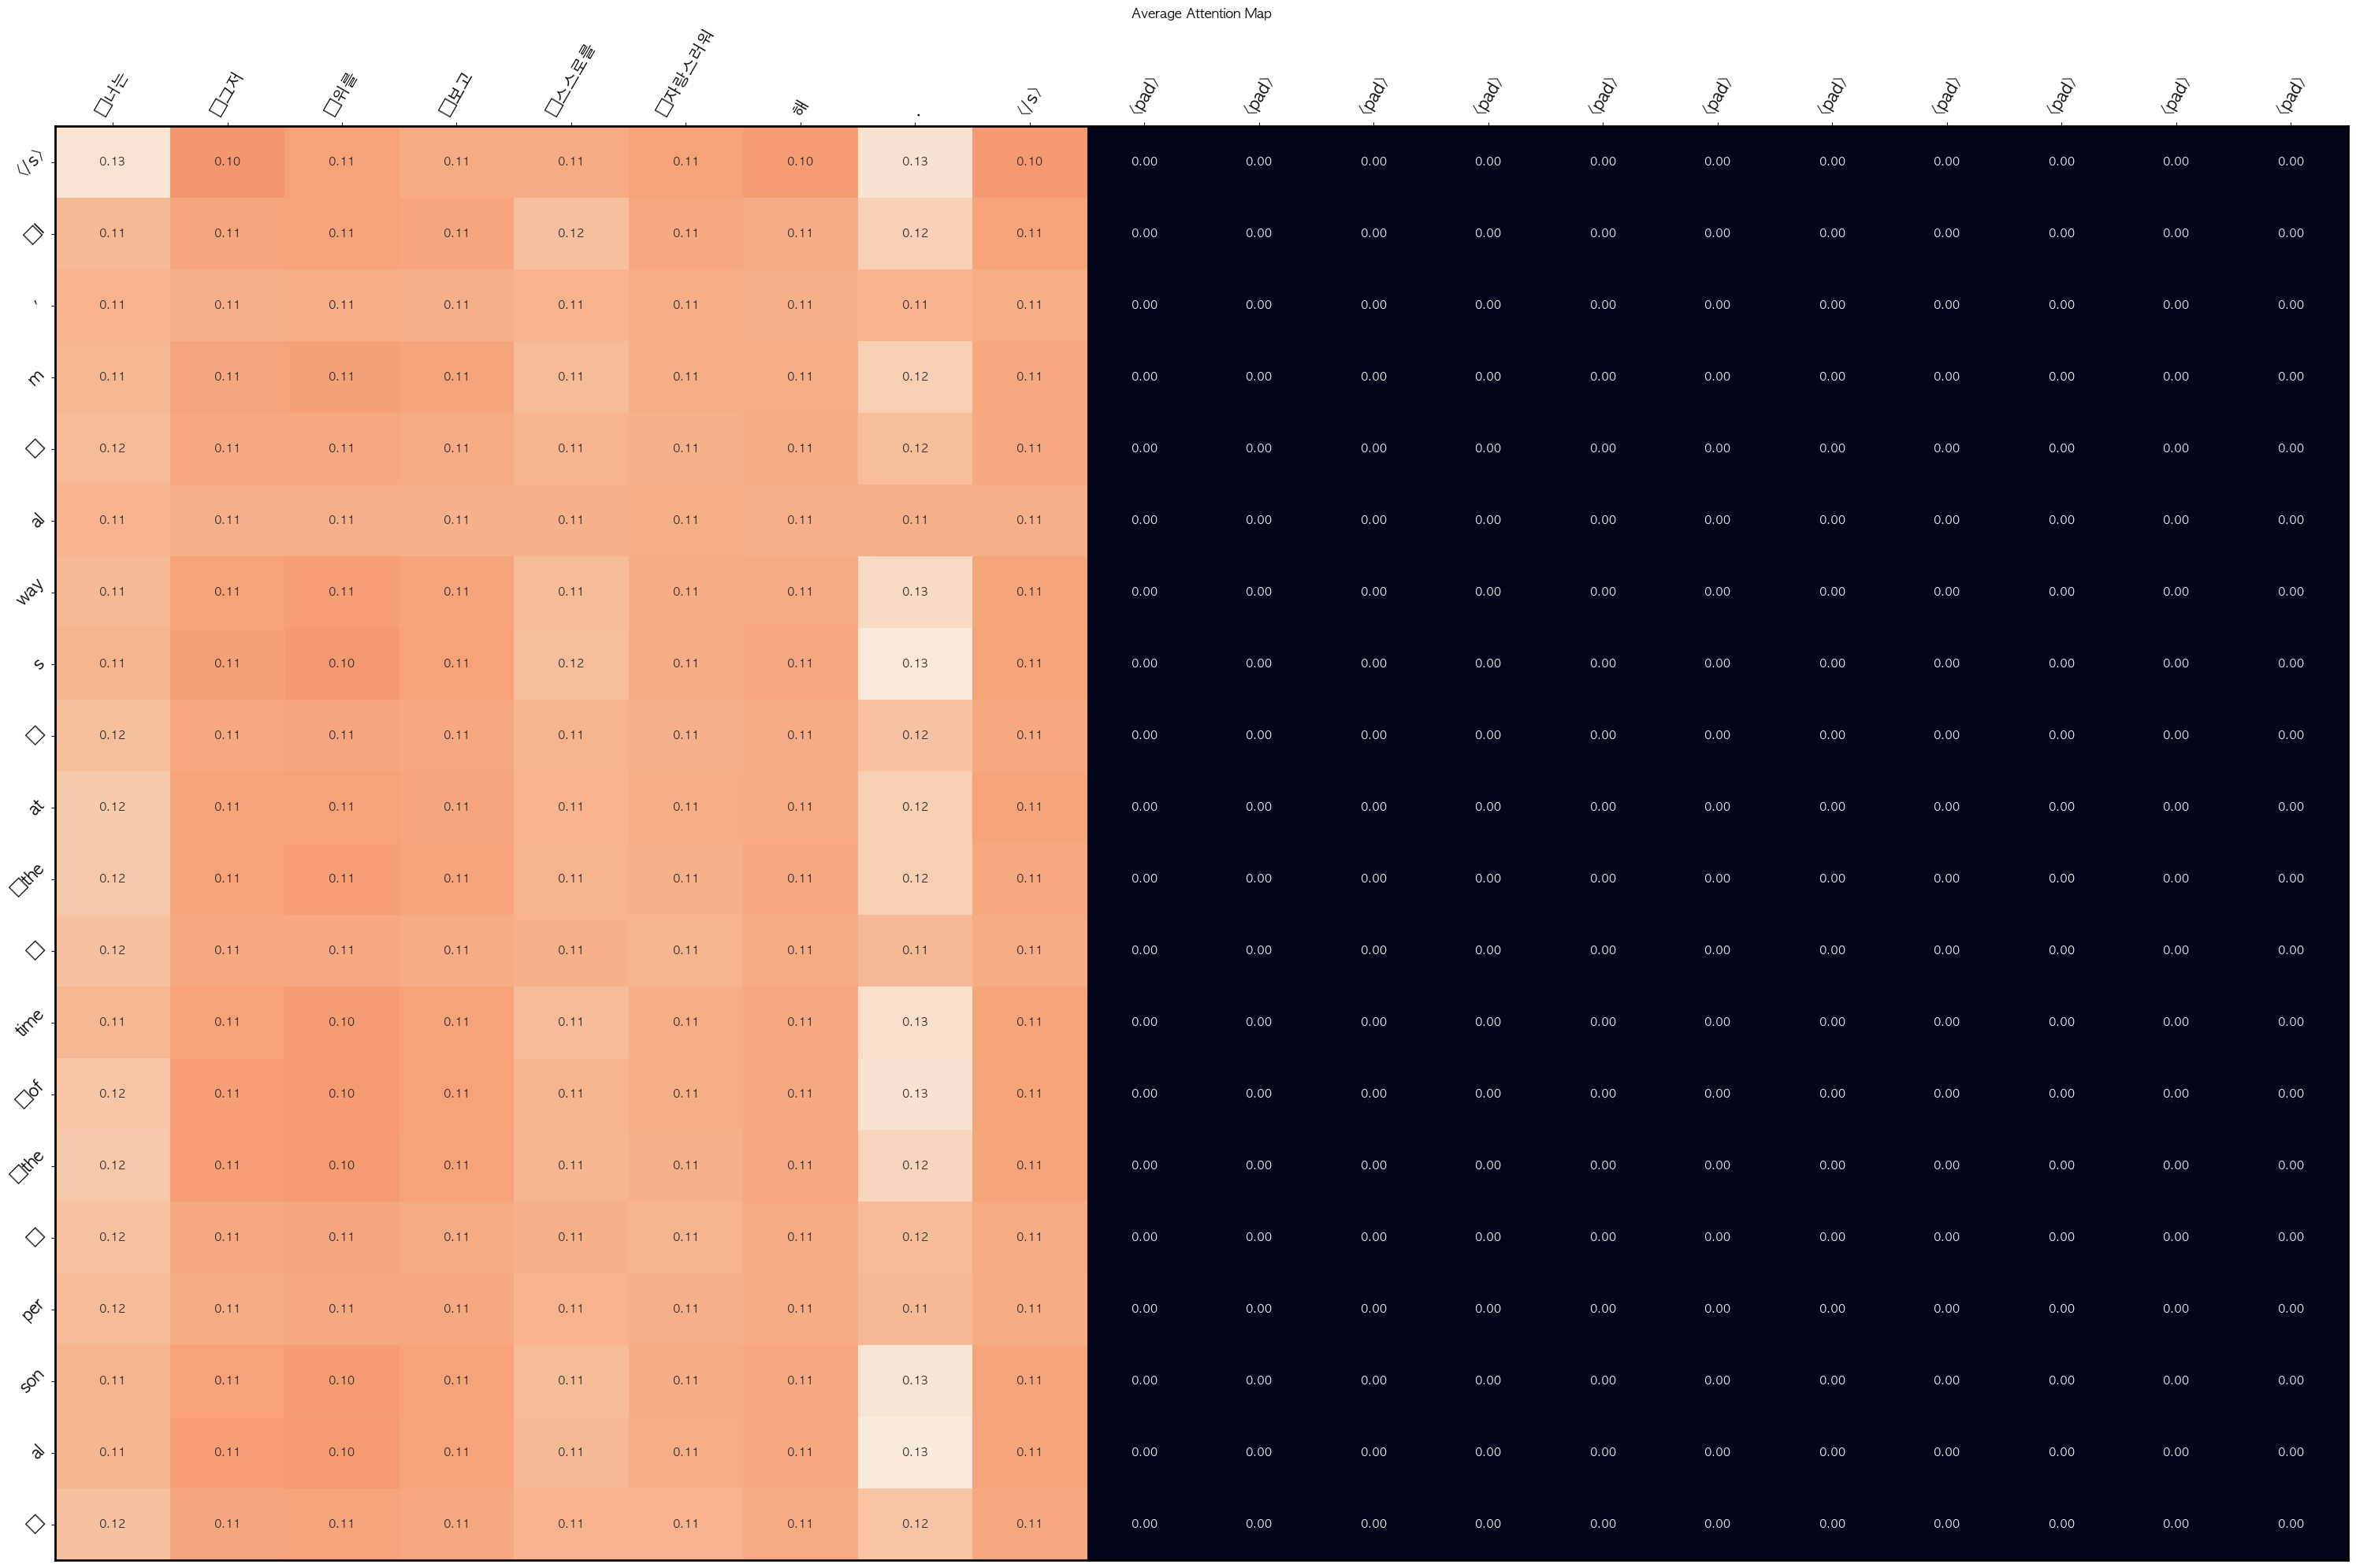

tensor([   0,   16,   12,  107,    9,  639, 6229,   10,    9, 2253,    4,    9,
        5772,    6,    4,    9, 4952, 4747,  639,    9, 3893, 2135,    2,    0],
       device='mps:0')
</s> I'm always at the time of the personal team.</s>


In [10]:
translated_sentence = inference("너는 그저 위를 보고 스스로를 자랑스러워해.")
print(translated_sentence)